In [1]:
import numpy as np
import pandas as pd

data = "/mnt/d/Data/Instacart/"

In [2]:
#train = pd.read_csv(data+"train.tsv", sep='\t', dtype={
#    'order_id': np.int32,
#    'user_id': np.int32,
#    'product_id': np.uint16,
#    'label': np.int8,
#    'seed': np.int8
#})

#valid = train[train['seed']>=3].drop('seed', axis=1)
#train = train[train['seed']<3].drop('seed', axis=1)

f = pd.read_hdf("/mnt/d/Data/Instacart/dataset.hdf", "train")

In [3]:
f.drop(['user_distinct_items', 'order_dow', 'order_hour_of_day'], axis=1, inplace=True)

train = f[f['seed']>=3].drop(['order_id', 'user_id', 'product_id', 'seed'], axis=1)
valid = f[f['seed']<3].drop(['order_id', 'user_id', 'product_id', 'seed'], axis=1)

del f

In [6]:
train.head()

,label,second_order_ratio,avg_reorder_ratio,aisle_id,department_id,user_product_order_cnt,user_prod_order_rate,user_prod_last_vacancy,user_prod_order_freq,user_reorder_ratio,...,user_avg_items,user_interval_avg,order_dow,order_hour_of_day,days_since_prior_order,product_week_prob,product_hour_prob,user_week_prob,user_hour_prob,user_days_since_prior_ratio
0,1,0.582500,4.473875,77,7,10,1.0,1,1.0,0.759259,...,0.305085,19.0,4,8,14.0,0.152580,0.059652,0.3,0.2,0.736842
2,0,0.529482,3.857058,23,19,10,1.0,1,1.0,0.759259,...,0.305085,19.0,4,8,14.0,0.130173,0.065318,0.3,0.2,0.736842
11,0,0.527426,3.082390,24,4,1,0.1,6,1.0,0.759259,...,0.305085,19.0,4,8,14.0,0.120317,0.069885,0.3,0.2,0.736842
12,0,0.495725,2.856348,24,4,1,0.1,6,1.0,0.759259,...,0.305085,19.0,4,8,14.0,0.111541,0.065484,0.3,0.2,0.736842
15,1,0.634271,4.278772,45,19,1,0.1,1,1.0,0.759259,...,0.305085,19.0,4,8,14.0,0.130106,0.052002,0.3,0.2,0.736842


<hr/>

Training using lightgbm



In [4]:
import lightgbm as lgb

X = lgb.Dataset(train.drop('label', axis=1), train['label'], categorical_feature=['aisle_id', 'department_id'])
V = lgb.Dataset(valid.drop('label', axis=1), valid['label'], categorical_feature=['aisle_id', 'department_id'], reference=X)

In [8]:
from sklearn.metrics import f1_score, roc_auc_score


TH = 0.20

def f1(preds, train_data):
    Yt = train_data.get_label()
    return 'f1', f1_score(Yt, preds>TH), True

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}

evals_result = {}

In [9]:
gbdt = lgb.train(params, X, valid_sets=V, feval=f1, evals_result=evals_result)

[1]	valid_0's auc: 0.821176	valid_0's f1: 0.177841
[2]	valid_0's auc: 0.823265	valid_0's f1: 0.177841
[3]	valid_0's auc: 0.824211	valid_0's f1: 0.177841
[4]	valid_0's auc: 0.82495	valid_0's f1: 0.177841
[5]	valid_0's auc: 0.825071	valid_0's f1: 0.177841
[6]	valid_0's auc: 0.825023	valid_0's f1: 0.177841
[7]	valid_0's auc: 0.825434	valid_0's f1: 0.177841
[8]	valid_0's auc: 0.826235	valid_0's f1: 0.177841
[9]	valid_0's auc: 0.826701	valid_0's f1: 0.177841
[10]	valid_0's auc: 0.827029	valid_0's f1: 0.251011
[11]	valid_0's auc: 0.827255	valid_0's f1: 0.30379
[12]	valid_0's auc: 0.827456	valid_0's f1: 0.33896
[13]	valid_0's auc: 0.827633	valid_0's f1: 0.36791
[14]	valid_0's auc: 0.827841	valid_0's f1: 0.384419
[15]	valid_0's auc: 0.828011	valid_0's f1: 0.396964
[16]	valid_0's auc: 0.828287	valid_0's f1: 0.405397
[17]	valid_0's auc: 0.828748	valid_0's f1: 0.413434
[18]	valid_0's auc: 0.829036	valid_0's f1: 0.418662
[19]	valid_0's auc: 0.829238	valid_0's f1: 0.423279
[20]	valid_0's auc: 0.829

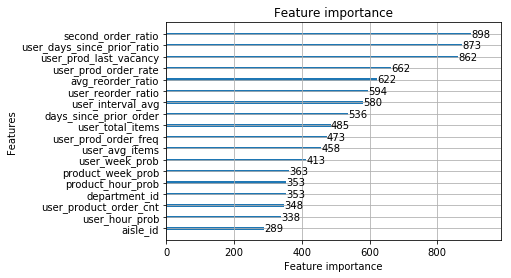

In [9]:
import matplotlib.pyplot as plt

ax = lgb.plot_importance(gbdt)
plt.show()

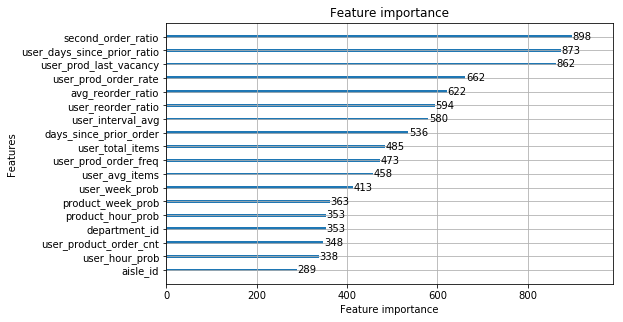

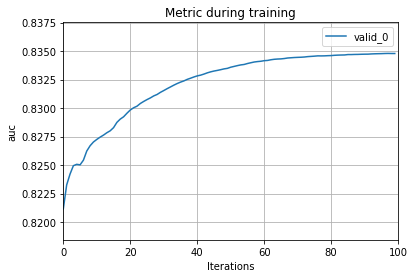

In [14]:
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

In [15]:
gbdt.predict(valid.drop('label', axis=1))

array([ 0.0425449 ,  0.04207708,  0.08774148, ...,  0.74720414,
        0.18101956,  0.88484696])

<hr/>

predict and submit

In [10]:
test = pd.read_hdf("/mnt/d/Data/Instacart/dataset.hdf", "test")
test.drop(['user_distinct_items', 'order_dow', 'order_hour_of_day'], axis=1, inplace=True)

In [11]:
train = train.append(valid)

In [12]:
import lightgbm as lgb

X = lgb.Dataset(train.drop('label', axis=1), train['label'], categorical_feature=['aisle_id', 'department_id'])


In [13]:
gbdt = lgb.train(params, X, num_boost_round=160)

In [14]:
Y = gbdt.predict(test.drop(['order_id', 'user_id', 'product_id'], axis=1))

In [24]:
test['label'] = Y>0.2

In [25]:
d = dict()
for row in test.itertuples():
    if row.label:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test.order_id:
    if order not in d:
        d[order] = 'None'

In [26]:
sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('result.csv', index=False)

In [21]:
train

,label,second_order_ratio,avg_reorder_ratio,user_reorder_ratio,days_since_prior_order,user_product_order_cnt,user_prod_order_rate,user_prod_last_vacancy,user_prod_order_freq
0,1,0.582500,4.473875,0.759259,14.0,10,1.000000,1,1.000000
2,0,0.529482,3.857058,0.759259,14.0,10,1.000000,1,1.000000
11,0,0.527426,3.082390,0.759259,14.0,1,0.100000,6,1.000000
12,0,0.495725,2.856348,0.759259,14.0,1,0.100000,6,1.000000
15,1,0.634271,4.278772,0.759259,14.0,1,0.100000,1,1.000000
18,0,0.582500,4.473875,0.515000,28.0,1,0.030303,24,1.000000
24,0,0.543279,3.699053,0.515000,28.0,5,0.151515,1,0.172414
26,0,0.487881,3.049811,0.515000,28.0,1,0.030303,13,1.000000
29,0,0.557770,3.134867,0.515000,28.0,1,0.030303,24,1.000000
30,0,0.564679,4.197768,0.515000,28.0,3,0.090909,6,0.230769
